In [1]:
import os
!nvidia-smi

Wed Jun  5 14:31:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| 31%   32C    P8             17W /  285W |    5978MiB /  16376MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/dzryk/antarctic-captions.git
%cd antarctic-captions/
!git clone https://github.com/openai/CLIP

E:\sourcecode\keep_learning\ml\experiment\antarctic-captions


Cloning into 'antarctic-captions'...
E:\sourcecode\keep_learning\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]
Cloning into 'CLIP'...


In [5]:
!pip3 install gdown
!pip3 install ftfy
!pip3 install transformers
!pip3 install git+https://github.com/PyTorchLightning/pytorch-lightning

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to c:\users\ping\appdata\local\temp\pip-req-build-wsodrp8g
  Resolved https://github.com/PyTorchLightning/pytorch-lightning to commit 5aadfa62508ee20735083900273c8e3ff5867602
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/PyTorchLightning/pytorch-lightning 'C:\Users\ping\AppData\Local\Temp\pip-req-build-wsodrp8g'
  Running command git submodule update --init --recursive -q
  Encountered 22 files that should have been pointers, but weren't:
        .notebooks/course_UvA-DL/01-introduction-to-pytorch.ipynb
        .notebooks/course_UvA-DL/02-activation-functions.ipynb
        .notebooks/course_UvA-DL/03-initialization-and-optimization.ipynb
        .notebooks/course_UvA-DL/04-inception-resnet-densenet.ipynb
        .notebooks/course_UvA-DL/05-transformers-and-MH-attention.ipynb
        .notebooks/course_UvA-DL/06-graph-neural-networks.ipynb
        .notebooks/course_UvA-DL/07-deep-energy-based-generative-models.ipynb
        .notebooks/course_UvA-DL/08-deep-autoencoders.ipynb
        .notebooks/course_UvA-DL/09-normalizing-flows.ipynb
        .notebooks/course_UvA-DL/10-autoregressive-image-modeling.ipynb
        .notebooks/course_U

In [8]:
# Download models and cache
!wget -m -np -c -U "eye02" -w 2 -R "index.html*" "https://the-eye.eu/public/AI/models/antarctic-captions/"

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\Gow/etc/wgetrc
--2024-06-05 14:47:01--  https://the-eye.eu/public/AI/models/antarctic-captions/
Resolving the-eye.eu... 162.213.130.6
Connecting to the-eye.eu|162.213.130.6|:443... connected.
OpenSSL: error:1407742E:SSL routines:SSL23_GET_SERVER_HELLO:tlsv1 alert protocol version
Unable to establish SSL connection.


In [10]:
import argparse
import io
import numpy as np
import torch
import torch.nn as nn
import requests
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

from CLIP import clip
from PIL import Image
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.utils import make_grid

import model
import utils

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

import os

os.getcwd()

Using device: cuda:0


'E:\\sourcecode\\keep_learning\\ml\\experiment\\antarctic-captions'

In [12]:
# Helper functions
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def load_image(img, preprocess):
    img = Image.open(fetch(img))
    return img, preprocess(img).unsqueeze(0).to(device)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def display_grid(imgs):
    reshaped = [F.to_tensor(x.resize((256, 256))) for x in imgs]
    show(make_grid(reshaped))


def clip_rescoring(args, net, candidates, x):
    textemb = net.perceiver.encode_text(
        clip.tokenize(candidates).to(args.device)).float()
    textemb /= textemb.norm(dim=-1, keepdim=True)
    similarity = (100.0 * x @ textemb.T).softmax(dim=-1)
    _, indices = similarity[0].topk(args.num_return_sequences)
    return [candidates[idx] for idx in indices[0]]


def loader(args):
    cache = []
    with open(args.textfile) as f:
        for line in f:
            cache.append(line.strip())
    cache_emb = np.load(args.embfile)
    net = utils.load_ckpt(args)
    net.cache = cache
    net.cache_emb = torch.tensor(cache_emb).to(args.device)
    preprocess = clip.load(args.clip_model, jit=False)[1]
    return net, preprocess


def caption_image(path, args, net, preprocess):
    captions = []
    img, mat = load_image(path, preprocess)
    table, x = utils.build_table(mat.to(device),
                                 perceiver=net.perceiver,
                                 cache=net.cache,
                                 cache_emb=net.cache_emb,
                                 topk=args.topk,
                                 return_images=True)
    table = net.tokenizer.encode(table[0], return_tensors='pt').to(device)
    out = net.model.generate(table,
                             do_sample=args.do_sample,
                             num_beams=args.num_beams,
                             temperature=args.temperature,
                             top_p=args.top_p,
                             num_return_sequences=args.num_return_sequences)
    candidates = []
    for seq in out:
        candidates.append(net.tokenizer.decode(seq, skip_special_tokens=True))
    captions = clip_rescoring(args, net, candidates, x[None, :])
    for c in captions[:args.display]:
        print(c)
    display_grid([img])
    return captions

In [15]:
# Settings
filedir = './models/'
args = argparse.Namespace(
    ckpt=f'{filedir}/-epoch=05-vloss=2.163.ckpt',
    textfile=f'{filedir}/postcache.txt',
    embfile=f'{filedir}/postcache.npy',
    clip_model='ViT-B/16',
    topk=10,
    num_return_sequences=1000,
    num_beams=1,
    temperature=1.0,
    top_p=1.0,
    display=5,
    do_sample=True,
    device=device
)

In [17]:
# Load checkpoint and preprocessor
net, preprocess = loader(args)

Lightning automatically upgraded your loaded checkpoint from v1.3.8 to v2.2.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint E:\sourcecode\keep_learning\ml\experiment\antarctic-captions\models\-epoch=05-vloss=2.163.ckpt`


In [18]:
# Images
img = 'https://images.unsplash.com/photo-1506744038136-46273834b3fb?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80'
img2 = 'https://images.unsplash.com/photo-1546561892-65bf811416b9?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80'
img3 = 'https://pbs.twimg.com/media/E7DyLY5WYAMu9km?format=png&name=small'
img4 = 'https://images.unsplash.com/photo-1580130379624-3a069adbffc5?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=968&q=80'
img5 = 'https://images.unsplash.com/photo-1499781350541-7783f6c6a0c8?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2315&q=80'
img6 = 'https://images.unsplash.com/photo-1541701494587-cb58502866ab?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80'
img7 = 'https://images.unsplash.com/photo-1602738328654-51ab2ae6c4ff?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1867&q=80'
img8 = 'https://images.unsplash.com/photo-1530025809667-1f4bcff8e60f?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=3640&q=80'
img9 = 'https://images.unsplash.com/photo-1587162146766-e06b1189b907?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2325&q=80'
img10 = 'https://images.unsplash.com/photo-1611974789855-9c2a0a7236a3?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2100&q=80'
img11 = 'https://images.unsplash.com/photo-1621981386829-9b458a2cddde?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=2100&q=80'
img12 = 'https://thumbs.dreamstime.com/b/toronto-sign-nathan-phillips-square-view-night-canada-121955940.jpg'

E:\sourcecode\keep_learning\.venv\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
E:\sourcecode\keep_learning\.venv\Lib\site-packages\transformers\generation\configuration_utils.py:563: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
E:\sourcecode\keep_learning\.venv\Lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


A photo show scenery in the wilderness featuring mountains surrounded by trees.
A mountain ridge with mountains, mountains, river, and a red colored sky. 
A lot of mountains and trees in Idaho are under an air haze from the sun.
Pictures of a view of a mountain behind a river flowing across the grassy landscape
a panoramic view of mountains next to a stream.


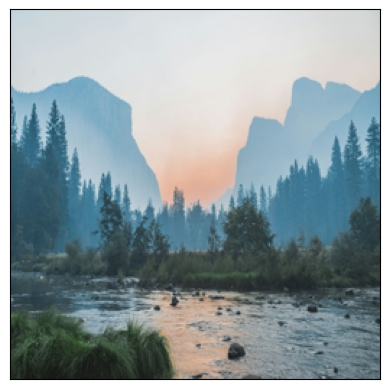

In [19]:
# Generate captions! Running multiple times will give different results.
# If you get a GPU memory error, decrease 'num_return_sequences'. This will impact caption quality.
captions = caption_image(img, args, net, preprocess)

A sign for the city of Toronto is lit up at night.
The neon sign for Ontario is on display in downtown Toronto. 
A sign from Toronto City Center is lit up to make a different color.
a single neon sign has been lit up in a park in Toronto. 
The city of Toronto is lit up with colorful neon sign on the ground.


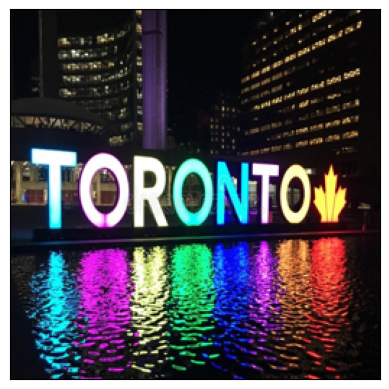

In [20]:
captions = caption_image(img12, args, net, preprocess)

In [ ]:
img13 = R"E:\share\PP包\海南炼化_SINOPEC_环管法Ⅲ\images\020A-SR201A-B.jpg"
captions = caption_image(img13, args, net, preprocess)